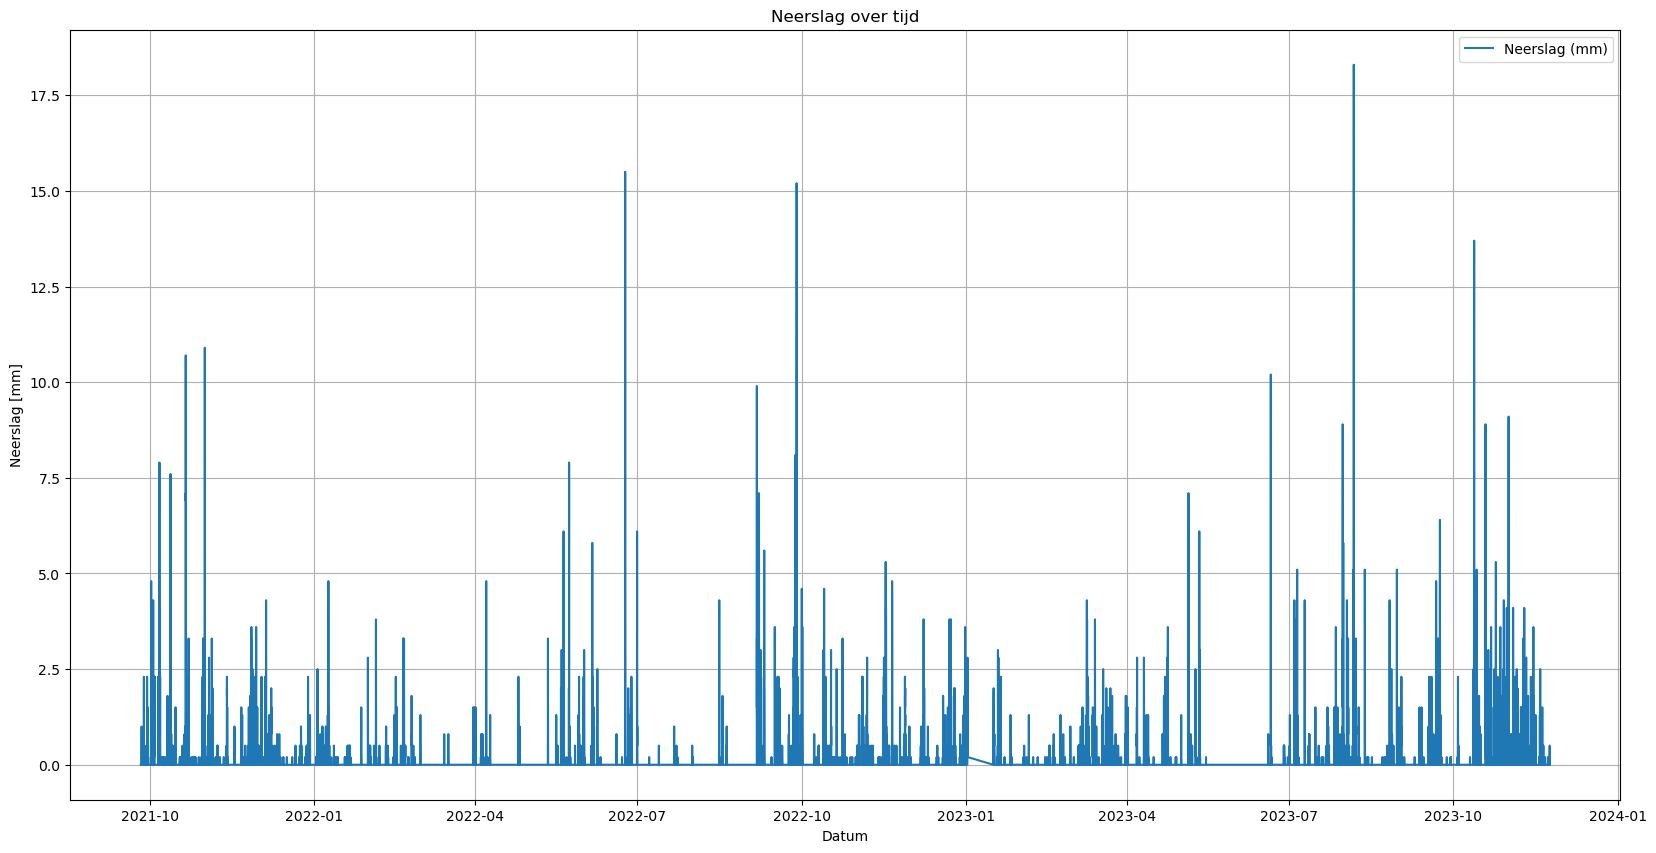

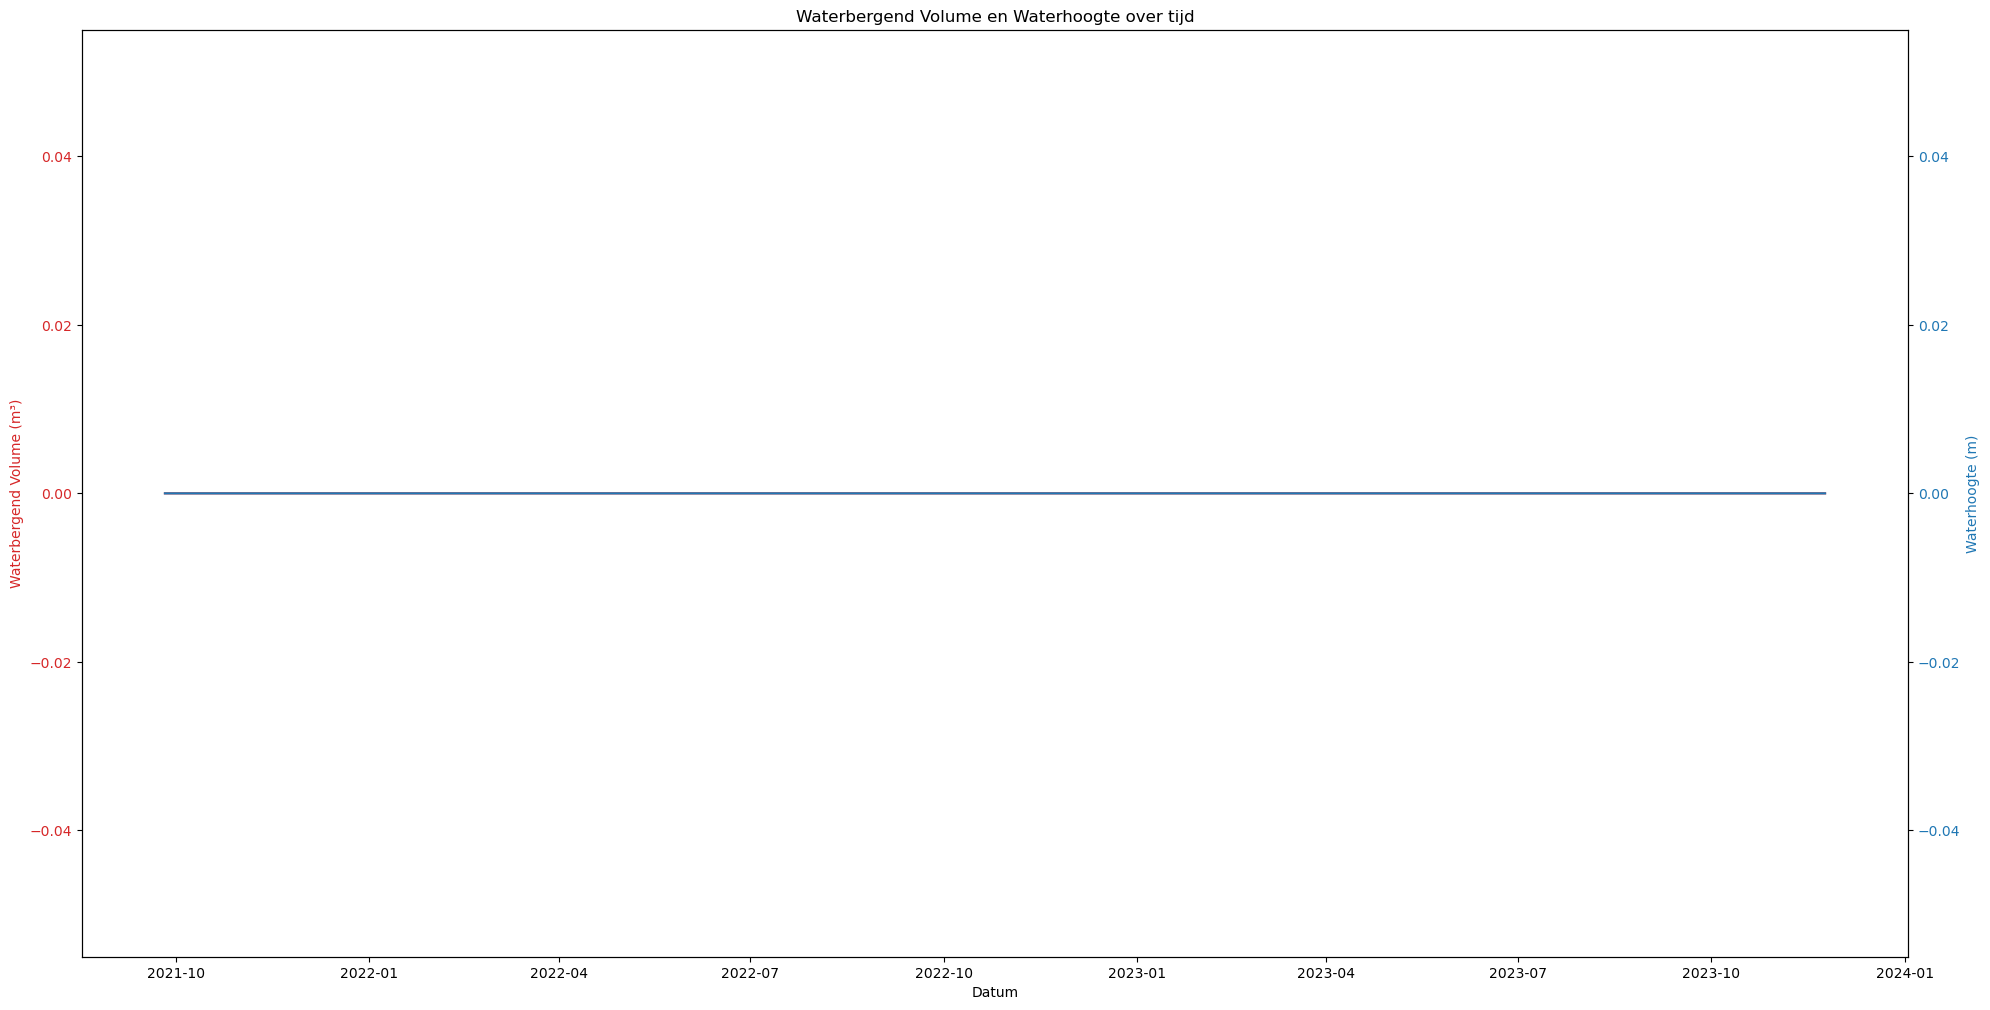

In [3]:
#Lijstje van de benodigde imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#Omzetten verkregen dataset KNMI naar lijst met gefilterde waardes

# Inladen neerslagdata
df_neerslag = pd.read_csv('Neerslag_Hoogmade.csv', skipinitialspace=True, header=0, sep=';')

# Maak een datum kolom
df_neerslag['DateTime'] = pd.to_datetime(df_neerslag['datum'])  # format is voor notatie van de import

# Zet 'neerslagintensiteit (mm/uur)' om naar numerieke waarden
df_neerslag['neerslagintensiteit (mm/uur)'] = pd.to_numeric(df_neerslag['neerslagintensiteit (mm/uur)'], errors='coerce')

# Vervang NaN door 0
df_neerslag['neerslagintensiteit (mm/uur)'].fillna(0, inplace=True)

# Plot de DateTime tegenover de RH
plt.figure(figsize=(20, 10))
plt.plot(df_neerslag["DateTime"], df_neerslag["neerslagintensiteit (mm/uur)"], label="Neerslag (mm)")
plt.title("Neerslag over tijd")
plt.xlabel("Datum")
plt.ylabel("Neerslag [mm]")
plt.grid(True)
plt.legend()
plt.show()

# Omzetten neerslag naar mm, daarna naar m
df_neerslag['neerslagintensiteit (mm/uur)'] = df_neerslag['neerslagintensiteit (mm/uur)'] / 1000

# Haal alle waarden van 'neerslagintensiteit (mm/uur)' op als lijst
neerslag_lijst = df_neerslag['neerslagintensiteit (mm/uur)'].tolist()

# Toon de lijst van alle waarden van 'neerslagintensiteit (mm/uur)'
#print("Lijst van alle waarden van 'neerslagintensiteit (mm/uur)':")
#print(neerslag_lijst)


#Invoer van KNMI dataset in het model van de waterbergende weg

# Parameters
A_hellend_dak = 660.88
A_vlak_dak = 56.12
A_rijweg_goot = 836.99
A_trottoir_goot = 532.36
A_parkeerplaatsen = 570.08

A_afstromend = A_hellend_dak + A_vlak_dak + A_rijweg_goot + A_trottoir_goot + A_parkeerplaatsen
A_inf_pakket = 1337.53   #Oppervlak van het bergend pakket (m^2)

k_bodem = 0.05/24/12   #Doorlatendheidscoëfficiënt van de bodem (m/5min)
k_rockflow = 200/24/12 #Doorlatendheidscoëfficiënt van de rockflow (m/5min)
por_bodem = 0.4
por_rockflow = 0.95
t0 = 0


tijdstappen = len(neerslag_lijst)

# Tijdstappen en initiële conditie
dt = 1  # Tijdstap (5 minuten)
t = np.arange(0, tijdstappen, dt)  # Tijdstappen
V = np.zeros(len(t))  # Array voor de bergingscapaciteit
h = np.zeros(len(t))  # Array voor de waterhoogte in het infiltratiepakket

# Initiële conditie
V[0] = 0.0  # Initiële bergingscapaciteit (m^3)

# Numerieke oplossing met behulp van de methode van Euler
for i in range(1, len(t)):
    dVdt = (neerslag_lijst[i] * A_afstromend - k_rockflow * A_inf_pakket)
    V[i] = max(0, V[i - 1] + dVdt * dt)
    h[i] = max(0, V[i] / por_rockflow / A_inf_pakket)

# Plot de numerieke oplossing voor het volume (verbeterde x-as)
#plt.figure(figsize=(20, 10))
#plt.plot(df_neerslag["DateTime"], V, label='Numerieke Oplossing (m^3)', marker='o', markersize=4, linestyle='-')
#plt.xlabel('Tijd (jaren)')  # Verander x-as label naar 'Tijd (jaren)'
#plt.ylabel('Bergingscapaciteit (m^3)')
#plt.title('Numerieke Oplossingen van de Bergingscapaciteit met Dagelijkse Neerslagsom')
#plt.legend()
#plt.grid(True)
#plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))  # Alleen de jaren laten zien
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#plt.xticks(rotation=45)  # Roteren van de waardes op de x-as
#plt.show()

# Plot de numerieke oplossing voor waterhoogte
#plt.figure(figsize=(20, 10))
#plt.plot(t, h, label='Numerieke Oplossing (m)', marker='o', markersize=4, linestyle='-')
#plt.xlabel('Tijd (uur)')
#plt.ylabel('Waterhoogte (m)')
#plt.title('Numerieke Oplossing van de Waterhoogte met Piekbelasting')
#plt.legend()
#plt.grid(True)
#plt.xticks(np.arange(0, 2, 1))  # Tijdstapmarkeringen om de 1 dag
#plt.show()

# Plot het waterbergend volume en de waterhoogte
fig, ax1 = plt.subplots(figsize=(20, 10))

color = 'tab:red'
ax1.set_xlabel('Datum')
ax1.set_ylabel('Waterbergend Volume (m³)', color=color)
ax1.plot(df_neerslag["DateTime"], V, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Waterhoogte (m)', color=color)
ax2.plot(df_neerslag["DateTime"], h, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Waterbergend Volume en Waterhoogte over tijd")
plt.show()

,object_id,description,well_covering_project_code,result_timestamp,water_level,water_level_unit,DateTime
0,5361029,PB1.03 (Rockflow),215231,26-6-2021 15:59,-1.102,m (NAP),2021-06-26 15:59:00
1,5361029,PB1.03 (Rockflow),215231,26-6-2021 16:59,-1.069,m (NAP),2021-06-26 16:59:00
2,5361029,PB1.03 (Rockflow),215231,26-6-2021 17:59,-1.056,m (NAP),2021-06-26 17:59:00
3,5361029,PB1.03 (Rockflow),215231,26-6-2021 18:59,-1.056,m (NAP),2021-06-26 18:59:00
4,5361029,PB1.03 (Rockflow),215231,26-6-2021 19:59,-1.051,m (NAP),2021-06-26 19:59:00
...,...,...,...,...,...,...,...
6427,5361029,PB1.03 (Rockflow),215231,22-11-2023 05:00,-1.068,m (NAP),2023-11-22 05:00:00
6428,5361029,PB1.03 (Rockflow),215231,22-11-2023 06:00,-1.076,m (NAP),2023-11-22 06:00:00
6429,5361029,PB1.03 (Rockflow),215231,22-11-2023 07:00,-1.073,m (NAP),2023-11-22 07:00:00
6430,5361029,PB1.03 (Rockflow),215231,22-11-2023 08:00,-1.072,m (NAP),2023-11-22 08:00:00


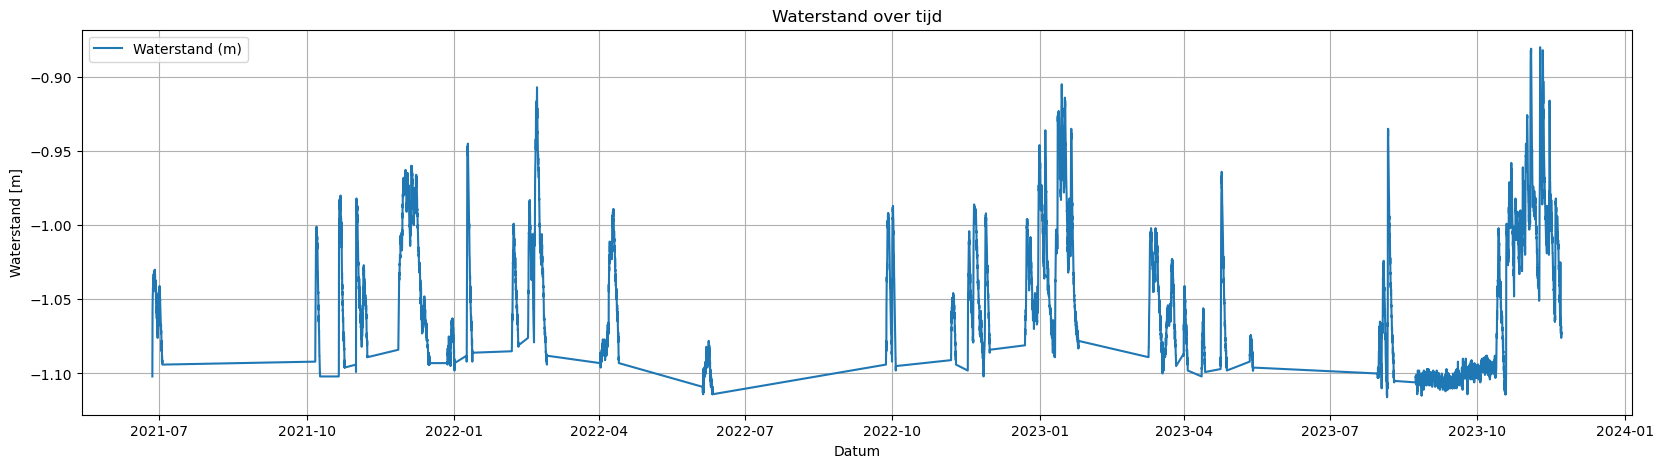

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Lees CSV-bestand in met puntkomma als scheidingsteken
df_PB03 = pd.read_csv('PB03_01122020_01122023.csv', skipinitialspace=True, header=0, sep=';')
# Maak een datum kolom
df_PB03['DateTime'] = pd.to_datetime(df_PB03['result_timestamp'], format='%d-%m-%Y %H:%M')

# Toon de kolomnamen
#print(df_PB03.columns)
display(df_PB03)
#df_PB03.head(20)

#plot de DateTime tegenover het water_level
plt.figure(figsize=(20, 5))
plt.plot(df_PB03["DateTime"], df_PB03["water_level"], label="Waterstand (m)")
plt.title("Waterstand over tijd")
plt.xlabel("Datum")
plt.ylabel("Waterstand [m]")
plt.grid(True)
plt.legend()
plt.show()

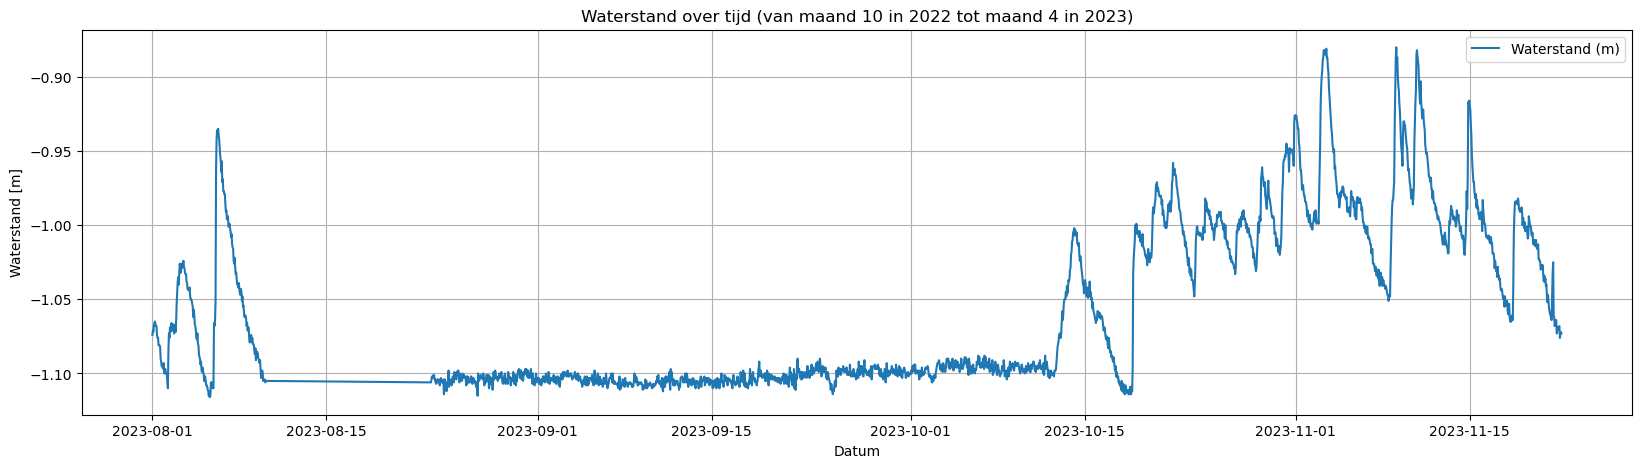

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Lees CSV-bestand in met puntkomma als scheidingsteken
df_PB03 = pd.read_csv('PB03_01122020_01122023.csv', skipinitialspace=True, header=0, sep=';')

# Maak een datum kolom
df_PB03['DateTime'] = pd.to_datetime(df_PB03['result_timestamp'], format='%d-%m-%Y %H:%M')

# Filter het DataFrame op het gewenste tijdsinterval (van maand 10 in 2022 tot maand 4 in 2023)
start_date = pd.to_datetime('2023-08-01')
end_date = pd.to_datetime('2023-11-30')
df_filtered = df_PB03[(df_PB03['DateTime'] >= start_date) & (df_PB03['DateTime'] <= end_date)]

# Plot de DateTime tegenover het water_level
plt.figure(figsize=(20, 5))
plt.plot(df_filtered["DateTime"], df_filtered["water_level"], label="Waterstand (m)")
plt.title("Waterstand over tijd (van maand 10 in 2022 tot maand 4 in 2023)")
plt.xlabel("Datum")
plt.ylabel("Waterstand [m]")
plt.grid(True)
plt.legend()
plt.show()

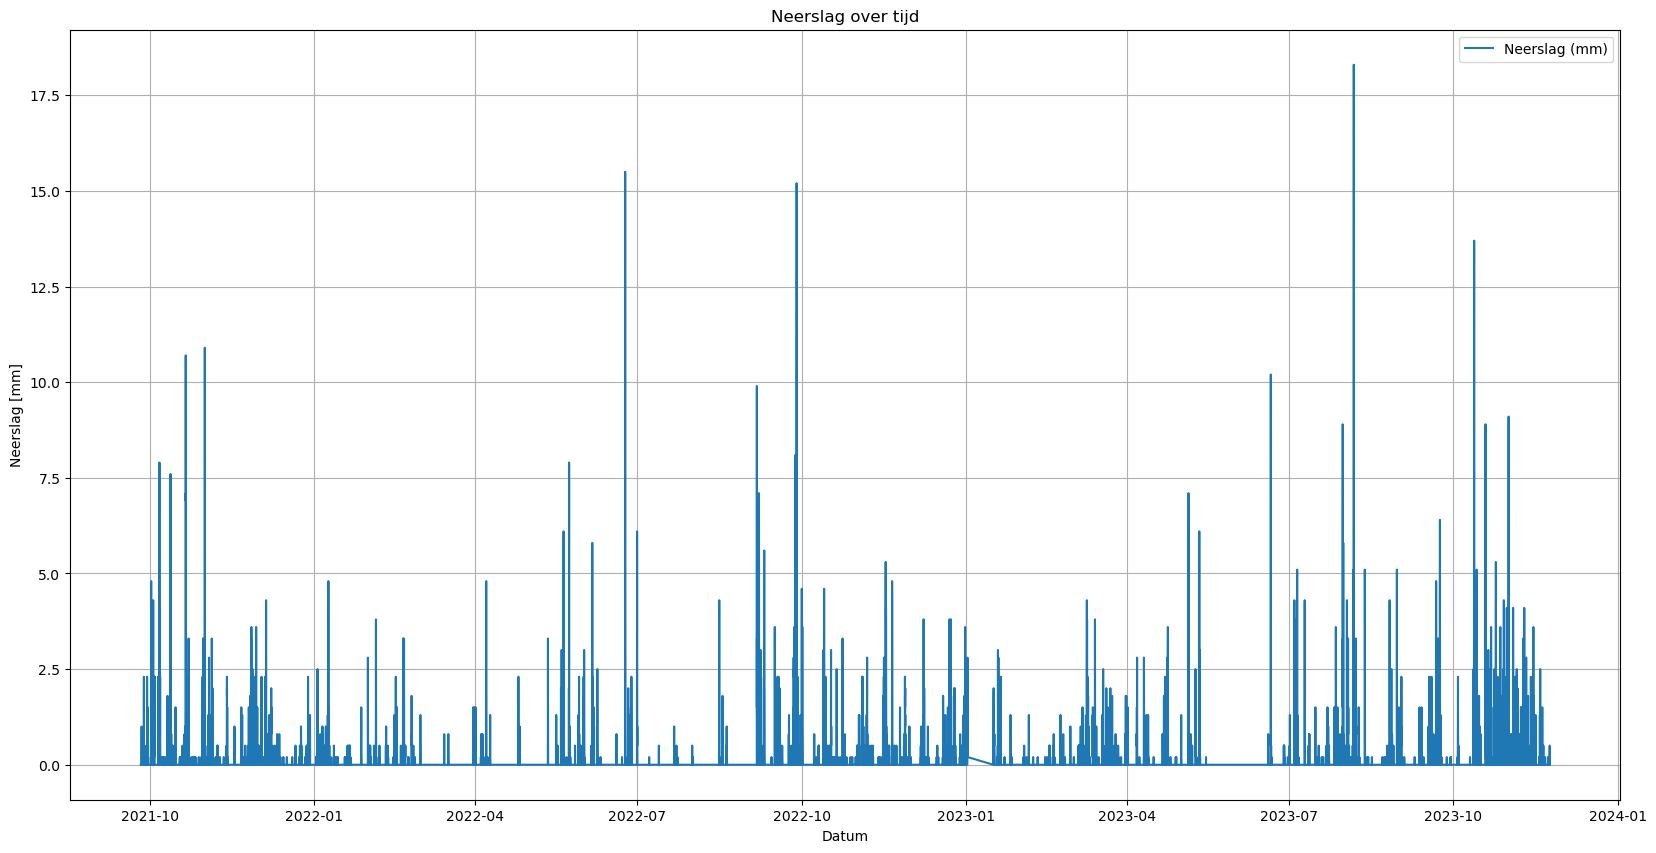

In [16]:
# Inladen neerslagdata
df_neerslag = pd.read_csv('Neerslag_Hoogmade.csv', skipinitialspace=True, header=0, sep=';')

# Maak een datum kolom
df_neerslag['DateTime'] = pd.to_datetime(df_neerslag['datum'])  # format is voor notatie van de import

# Zet 'neerslagintensiteit (mm/uur)' om naar numerieke waarden
df_neerslag['neerslagintensiteit (mm/uur)'] = pd.to_numeric(df_neerslag['neerslagintensiteit (mm/uur)'], errors='coerce')

# Vervang NaN door 0
df_neerslag['neerslagintensiteit (mm/uur)'].fillna(0, inplace=True)

# Plot de DateTime tegenover de RH
plt.figure(figsize=(20, 10))
plt.plot(df_neerslag["DateTime"], df_neerslag["neerslagintensiteit (mm/uur)"], label="Neerslag (mm)")
plt.title("Neerslag over tijd")
plt.xlabel("Datum")
plt.ylabel("Neerslag [mm]")
plt.grid(True)
plt.legend()
plt.show()

# Omzetten neerslag naar mm, daarna naar m
df_neerslag['neerslagintensiteit (mm/uur)'] = df_neerslag['neerslagintensiteit (mm/uur)'] / 1000

# Haal alle waarden van 'neerslagintensiteit (mm/uur)' op als lijst
neerslag_lijst = df_neerslag['neerslagintensiteit (mm/uur)'].tolist()

# Toon de lijst van alle waarden van 'neerslagintensiteit (mm/uur)'
#print("Lijst van alle waarden van 'neerslagintensiteit (mm/uur)':")
#print(neerslag_lijst)
